# MNIST Digits - Basic Convolutional Neural Network (CNN)


In [8]:
!pip install keras-tuner --upgrade
!pip install extra-keras-datasets
!pip install tensorflow
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 28.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 28.1 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 26.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.3/300.3 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 29.0 MB/s eta 0:00:0000:0100:01


In [1]:
# Common imports
import sys
import os
import sklearn
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from extra_keras_datasets import emnist

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib.pyplot as plt

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

import keras_tuner

2023-03-24 07:23:47.952274: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-24 07:23:49.273138: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-24 07:23:49.273371: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-24 07:23:51.119293: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

**Dataset**

In [2]:
# load MNIST digits dataset
(X_train_full, y_train_full), (X_test, y_test) = emnist.load_data(type='digits')

INFO:root:Loading dataset = emnist


In [3]:
# Add channel for greyscale image required for CNN
X_train_full = np.reshape(X_train_full, (-1,28,28,1))
X_test = np.reshape(X_test, (-1,28,28,1))
X_train_full.shape, X_test.shape

((240000, 28, 28, 1), (40000, 28, 28, 1))

In [4]:
# Create validation set from full training set
# Scale pixel value between 0 and 1 

X_valid, X_train = X_train_full[:24000] / 255., X_train_full[24000:] / 255.
y_valid, y_train = y_train_full[:24000], y_train_full[24000:]
X_test = X_test / 255.

In [5]:
y_train

array([7, 9, 4, ..., 1, 1, 0], dtype=uint8)

**Plots**

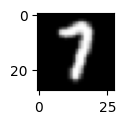

In [6]:
plt.figure(figsize = (1,1))
plt.imshow(X_train[0], cmap=plt.get_cmap('gray'))

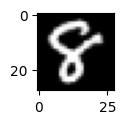

In [7]:
plt.figure(figsize = (1,1))
plt.imshow(X_train[10], cmap=plt.get_cmap('gray'))

# **Tuning**

In [10]:
from keras.layers.serialization import activation

early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

def build_model(hp):
    hp_conv_layers = hp.Int("conv_layers", 1, 3, default=3) 
    hp_dropout_rate=hp.Choice("dropout_rate", values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5]) 
    hp_activation=hp.Choice('activation', values=['relu', 'tanh']) # relu will return 0 in case of negative values
    hp_optimizer = hp.Choice('optimizer', values=['SGD'])
    optimizer = tf.keras.optimizers.get(hp_optimizer)
    optimizer.learning_rate = hp.Choice("learning_rate", [0.1, 0.01, 0.001], default=0.01)
   
    model = tf.keras.Sequential()
    for i in range(hp_conv_layers):
        # Add CNN layer
        model.add(tf.keras.layers.Conv2D(
            filters=hp.Int("filters_" + str(i), 4, 32, step=4, default=8),
            kernel_size=hp.Int("kernel_size_" + str(i), 3, 5),
            activation=hp_activation,
            padding="same"))
        # Add max pooling
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
        # Flatten the output to pass the to the fully connected layer
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dropout(rate=hp_dropout_rate)) # reduce overfitting
    # return probability of the different classes with activation function
    model.add(tf.keras.layers.Dense(units=10, activation="softmax")) # 10 classes for output
    
    model.compile(
        loss="sparse_categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer,
    )
    return model

In [ ]:
# Tune hyperparameters to find best combination for dataset
tuner = keras_tuner.RandomSearch(build_model,
                    objective='val_accuracy',
                    max_trials = 5)
# search best parameter
tuner.search(x=X_train,y=y_train,epochs=1,validation_data=(X_valid,y_valid),callbacks=[early_stopping_cb])

models = tuner.get_best_models(num_models=3)
tuner.results_summary()

model=tuner.get_best_models(num_models=1)[0]

INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json


INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json


INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


# **Save/Load model**

In [ ]:
model.save("MNIST_Digits_CNN");

In [8]:
model = keras.models.load_model('MNIST_Digits_CNN')       
model.summary()

2023-03-24 07:24:59.952316: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-24 07:24:59.952458: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-24 07:24:59.952503: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (37bc5f642d76): /proc/driver/nvidia/version does not exist
2023-03-24 07:24:59.957744: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 20)        200       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 8)         1448      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 8)        0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 1568)              0         
                                                                 
 dropout (Dropout)           (None, 1568)              0         
                                                                 
 dense (Dense)               (None, 10)                15690     
                                                        

In [11]:
history = model.fit(X_train, y_train, epochs=3, validation_data=(X_valid, y_valid),callbacks=[early_stopping_cb])

Epoch 1/3
6750/6750 [==============================] - 142s 21ms/step - loss: 0.0409 - accuracy: 0.9878 - val_loss: 0.0422 - val_accuracy: 0.9877
Epoch 2/3
6750/6750 [==============================] - 178s 26ms/step - loss: 0.0411 - accuracy: 0.9875 - val_loss: 0.0344 - val_accuracy: 0.9905
Epoch 3/3
6750/6750 [==============================] - 170s 25ms/step - loss: 0.0407 - accuracy: 0.9877 - val_loss: 0.0322 - val_accuracy: 0.9914


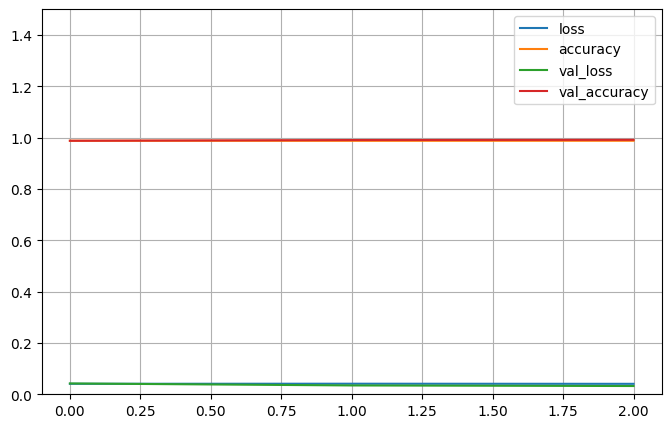

In [12]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1.5)
plt.show()

# **Test**

In [13]:
score = model.evaluate(X_test, y_test)

1250/1250 [==============================] - 5s 4ms/step - loss: 0.0293 - accuracy: 0.9916


In [14]:
pred_value = model.predict(X_test[:10])
y_pred = np.argmax(pred_value,axis=1)
print(y_pred)
print(y_test[:10])

1/1 [==============================] - 0s 76ms/step
[0 9 7 9 2 2 3 1 0 0]
[0 9 7 9 2 2 3 1 0 0]


In [15]:
p = model.predict(X_test)
p = np.argmax(p,axis=1)
y = y_test
correct = np.nonzero(p==y)[0]
incorrect = np.nonzero(p!=y)[0]

print("Correct predicted classes:",correct.shape[0])
print("Incorrect predicted classes:",incorrect.shape[0])

1250/1250 [==============================] - 5s 4ms/step
Correct predicted classes: 39665
Incorrect predicted classes: 335


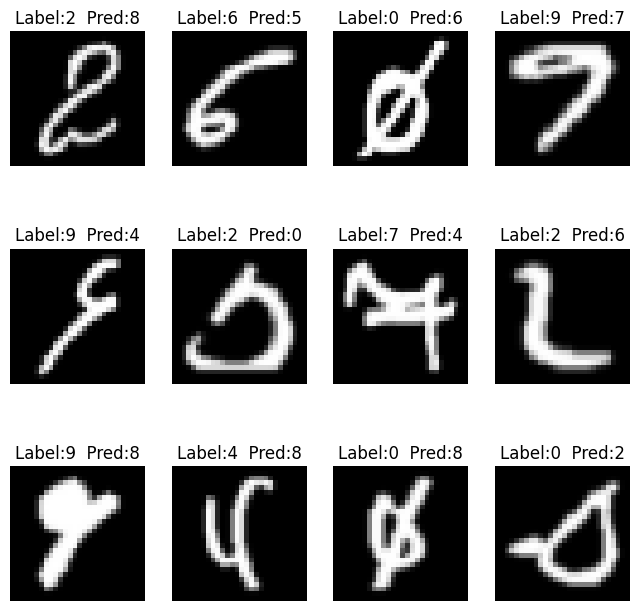

In [16]:
f, ax = plt.subplots(3,4, figsize=(8,8))

for i, indx in enumerate(incorrect[:12]):
    ax[i//4, i%4].imshow(X_test[indx].reshape(28,28,1), cmap=plt.get_cmap('gray'))
    ax[i//4, i%4].axis('off')
    ax[i//4, i%4].set_title("Label:{}  Pred:{}".format(y_test[indx],p[indx]))
plt.show()    